Aircraft A320#1 has 0.58 probability of breaking down at 2024-09-14 08:27:45.190600 until 2024-09-14 09:27:45.190600
Aircraft A320#3 has 0.28 probability of breaking down at 2024-09-14 10:19:29.934712 until 2024-09-14 11:19:29.934712
State space shape: (4, 40)
Aircraft A320#1 has 0.15 probability of breaking down at 2024-09-14 17:36:06.421782 until 2024-09-14 18:36:06.421782
Aircraft A320#3 has 0.36 probability of breaking down at 2024-09-14 15:32:30.229738 until 2024-09-14 16:32:30.229738
State space shape: (4, 40)
Observation shape: (1, 320)
Step 0:
Flights Dict:
{1: {'Orig': 'CDG', 'Dest': 'FRA', 'DepTime': '07:45', 'ArrTime': '10:00', 'PrevFlight': 0}, 2: {'Orig': 'DUB', 'Dest': 'TXL', 'DepTime': '10:07', 'ArrTime': '11:43', 'PrevFlight': 0}, 3: {'Orig': 'FRA', 'Dest': 'IST', 'DepTime': '14:05', 'ArrTime': '17:07', 'PrevFlight': 0}, 4: {'Orig': 'FRA', 'Dest': 'IST', 'DepTime': '10:15', 'ArrTime': '11:58', 'PrevFlight': 0}, 5: {'Orig': 'AMS', 'Dest': 'BCN', 'DepTime': '13:20', 'ArrT

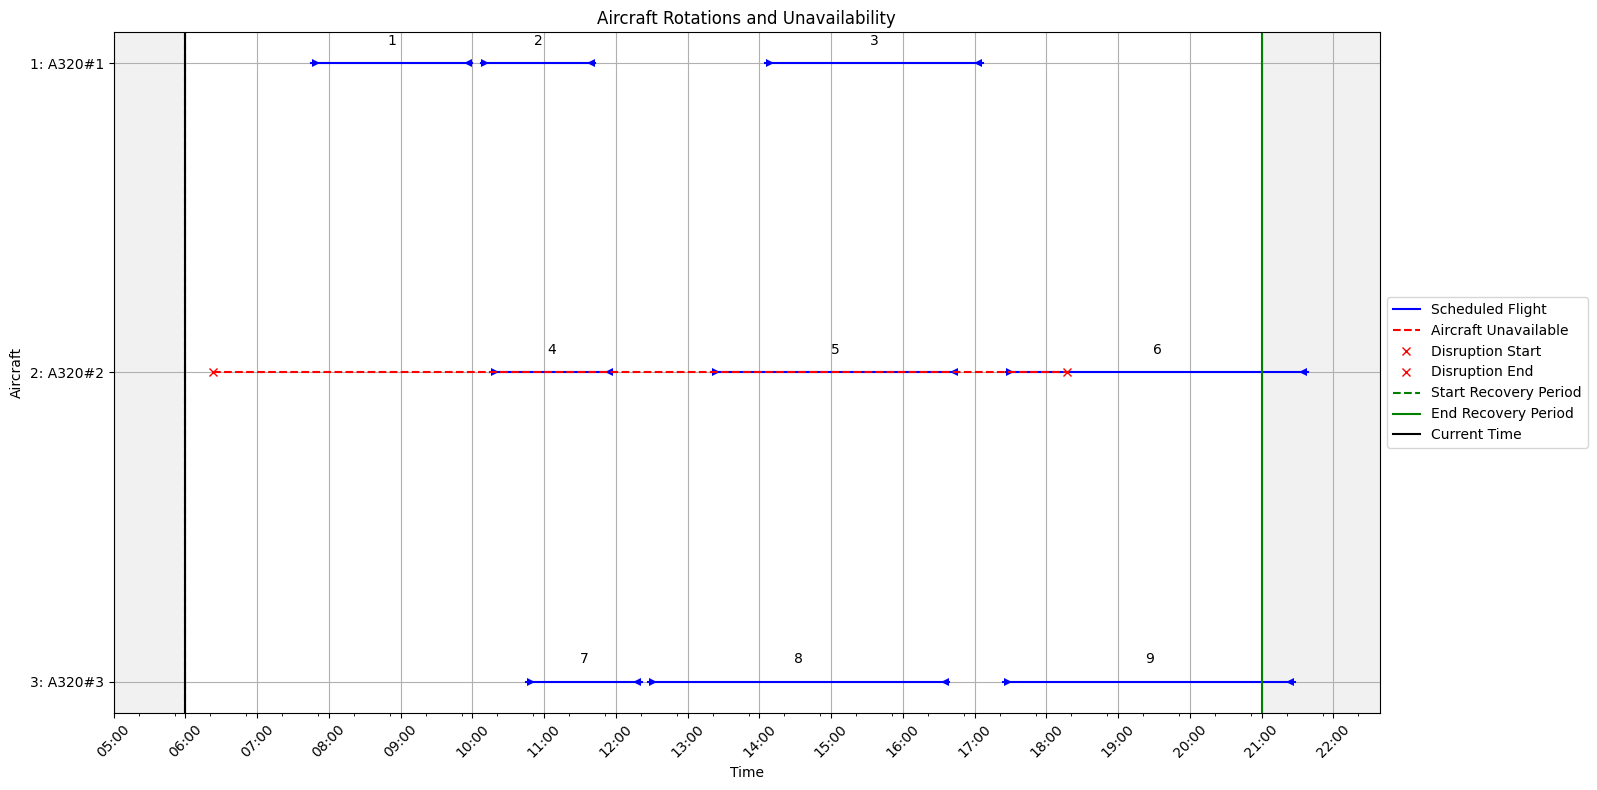

│ Target Aircraft    │ Target Flight      │ Current Time       │ Time Until End     │
│          2         │          4         │          0         │         900        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   0.58    148   208 |     1   105   240 |     2   247   343 |     3   485   667 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00     23   737 |     4   255   358 |     5   440   647 |     6   686   939 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   0.28    259   319 |     7

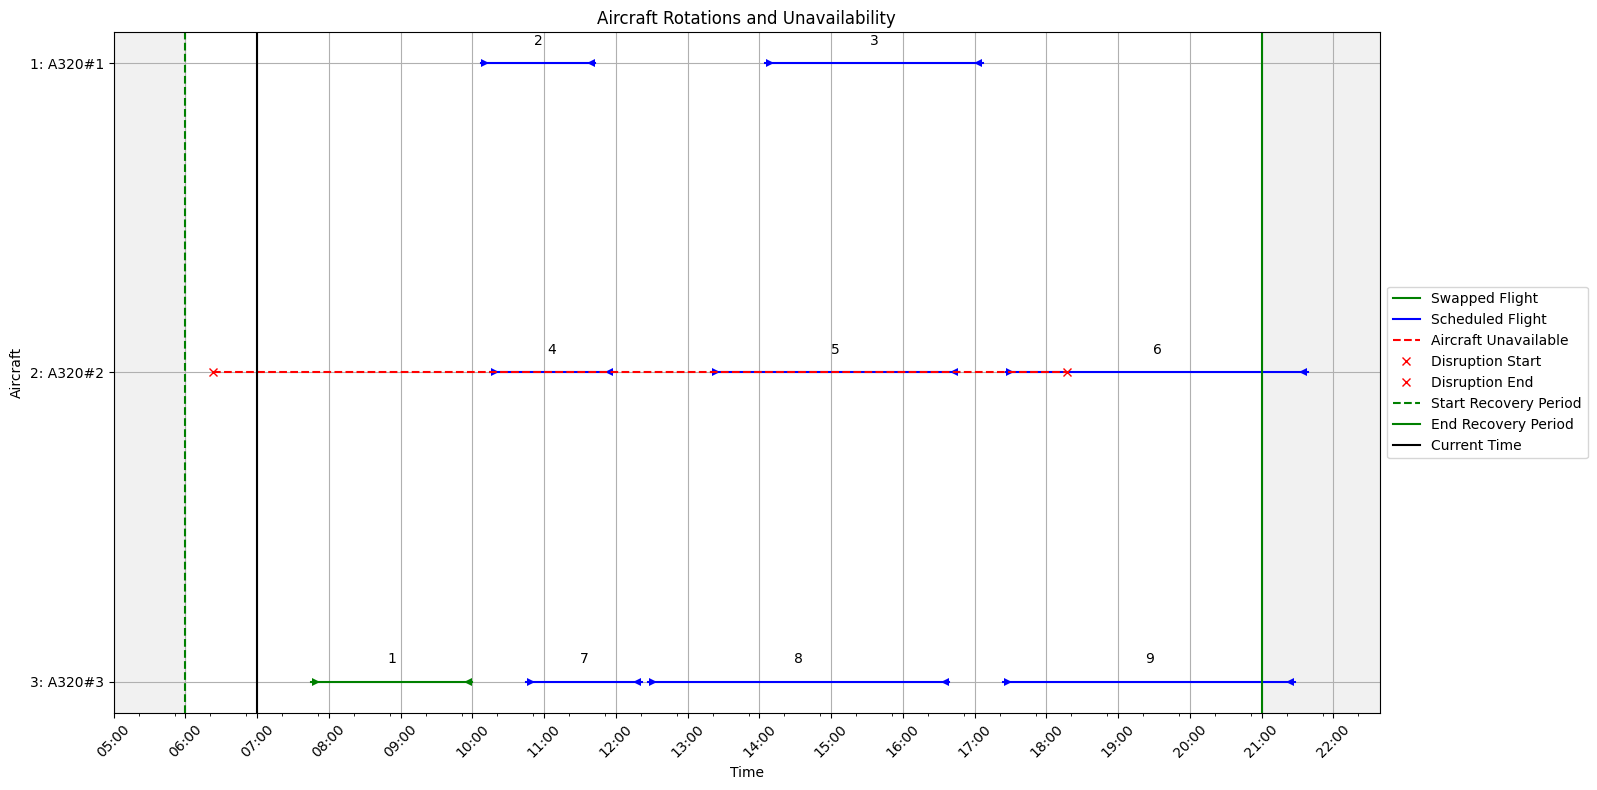

│ Target Aircraft    │ Target Flight      │ Current Time       │ Time Until End     │
│          2         │          4         │         60         │         840        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   0.15    696   756 |     2   247   343 |     3   485   667 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00     23   737 |     4   255   358 |     5   440   647 |     6   686   939 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   0.36    573   633 |     1

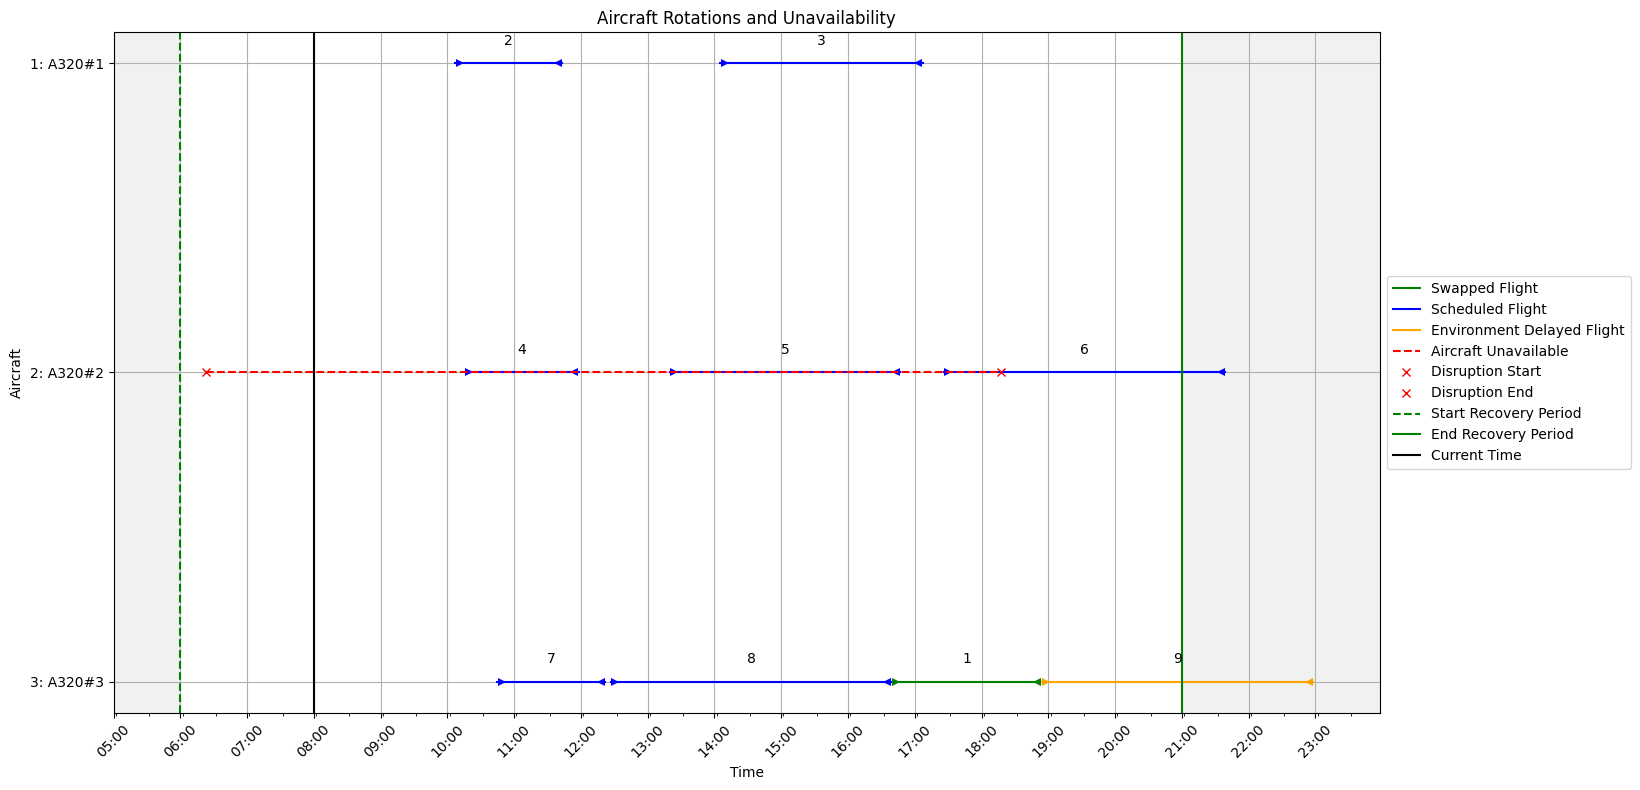

│ Target Aircraft    │ Target Flight      │ Current Time       │ Time Until End     │
│          2         │          4         │         120        │         780        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   0.15    696   756 |     2   247   343 |     3   485   667 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00     23   737 |     4   255   358 |     5   440   647 |     6   686   939 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   0.36    573   633 |     7

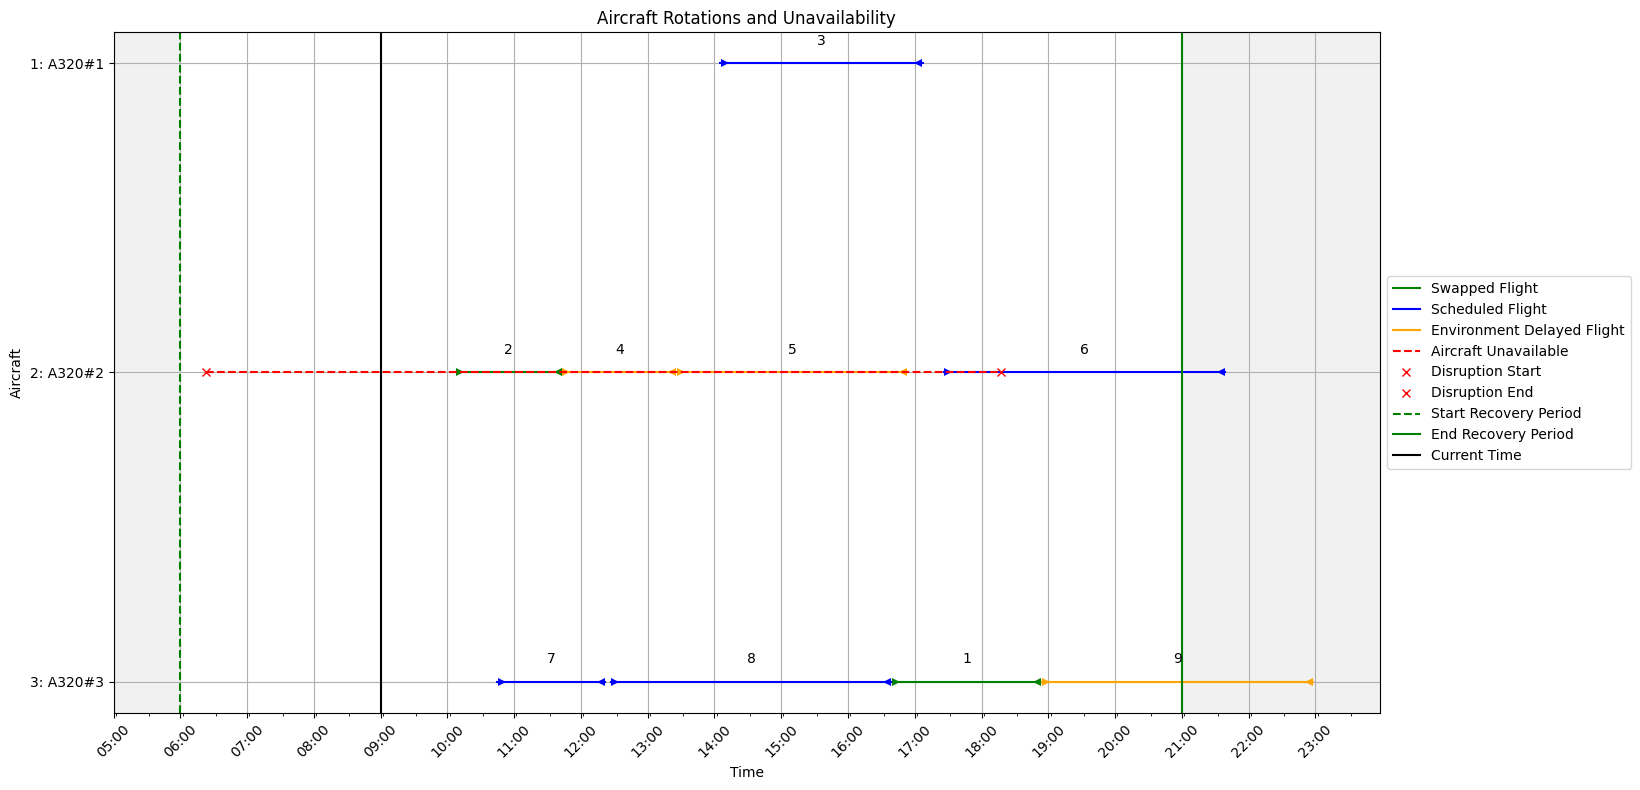

│ Target Aircraft    │ Target Flight      │ Current Time       │ Time Until End     │
│          2         │          2         │         180        │         720        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   0.15    696   756 |     3   485   667 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00     23   737 |     2   247   343 |     4   343   446 |     5   446   653 |     6   686   939 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   0.36    573   633 |     7

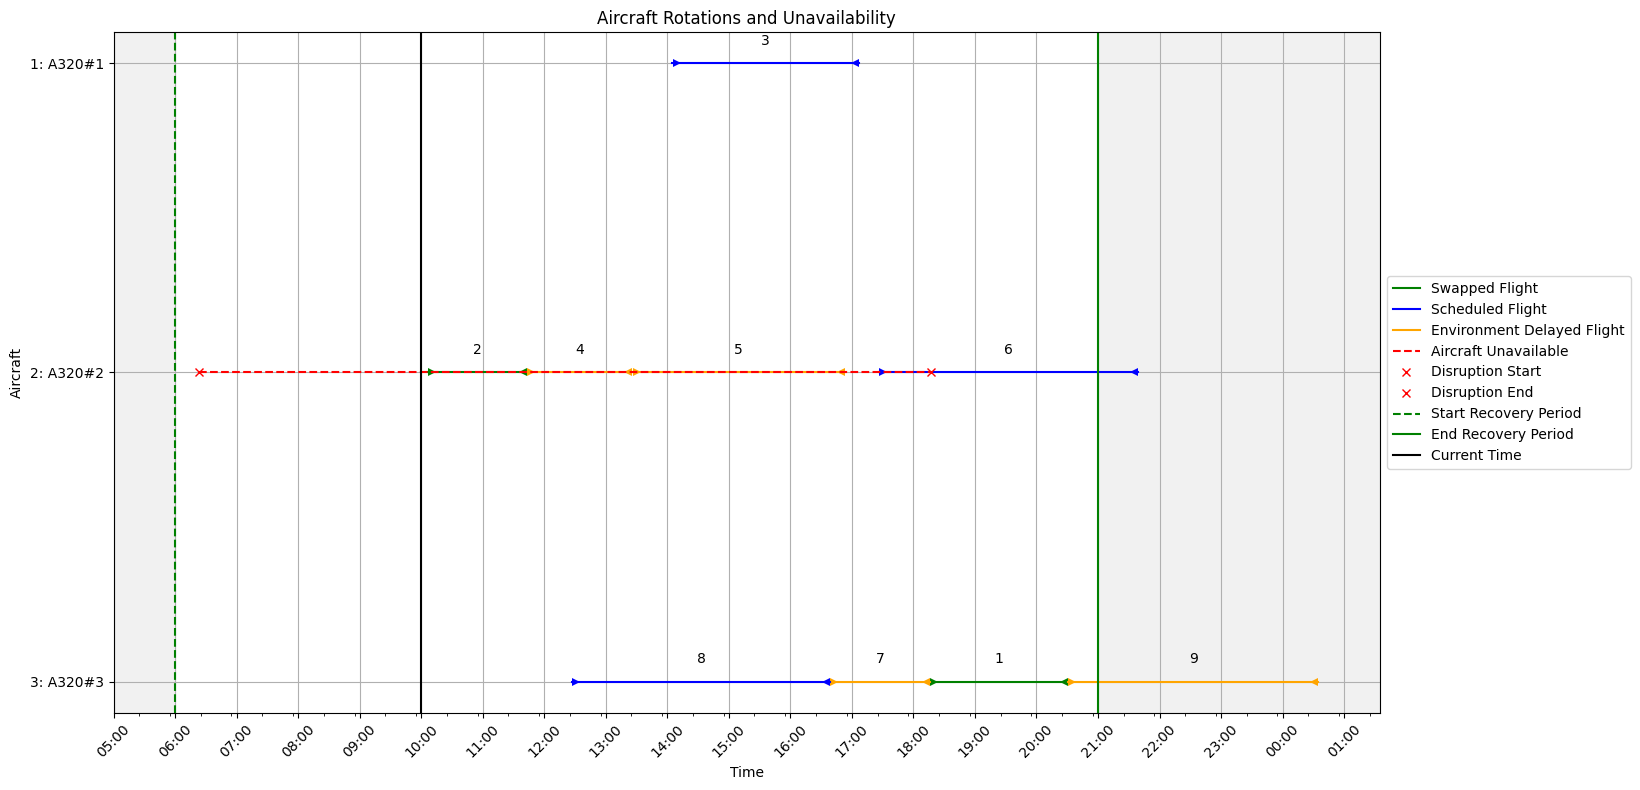

│ Target Aircraft    │ Target Flight      │ Current Time       │ Time Until End     │
│          2         │          2         │         240        │         660        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   0.15    696   756 |     3   485   667 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00     23   737 |     2   247   343 |     4   343   446 |     5   446   653 |     6   686   939 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   0.36    573   633 |     8

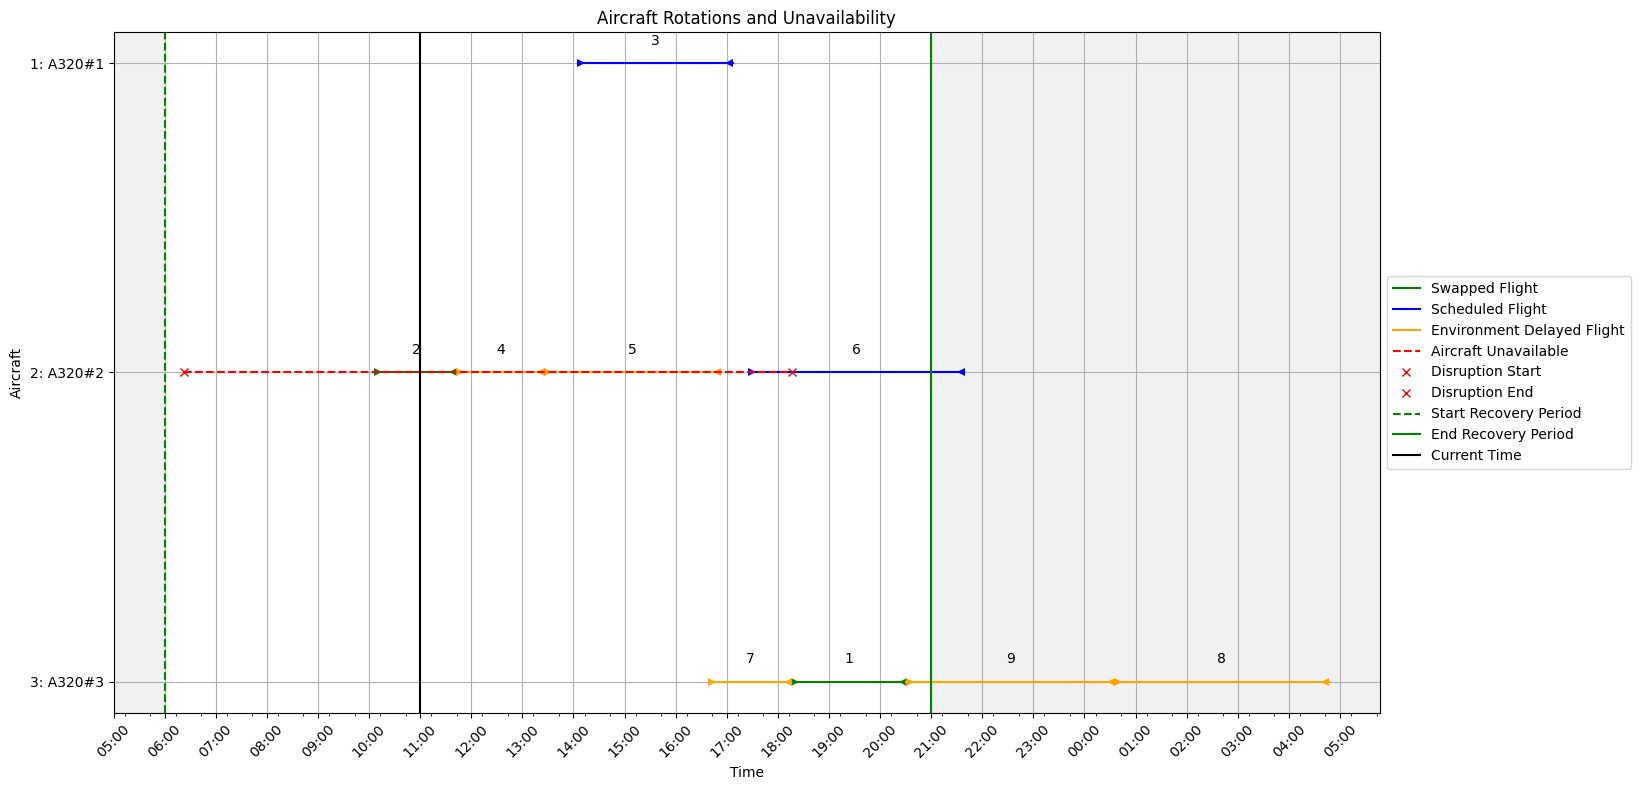

│ Target Aircraft    │ Target Flight      │ Current Time       │ Time Until End     │
│          2         │          4         │         300        │         600        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   0.15    696   756 |     3   485   667 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00     23   737 |     2   247   343 |     4   343   446 |     5   446   653 |     6   686   939 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   0.36    573   633 |     7

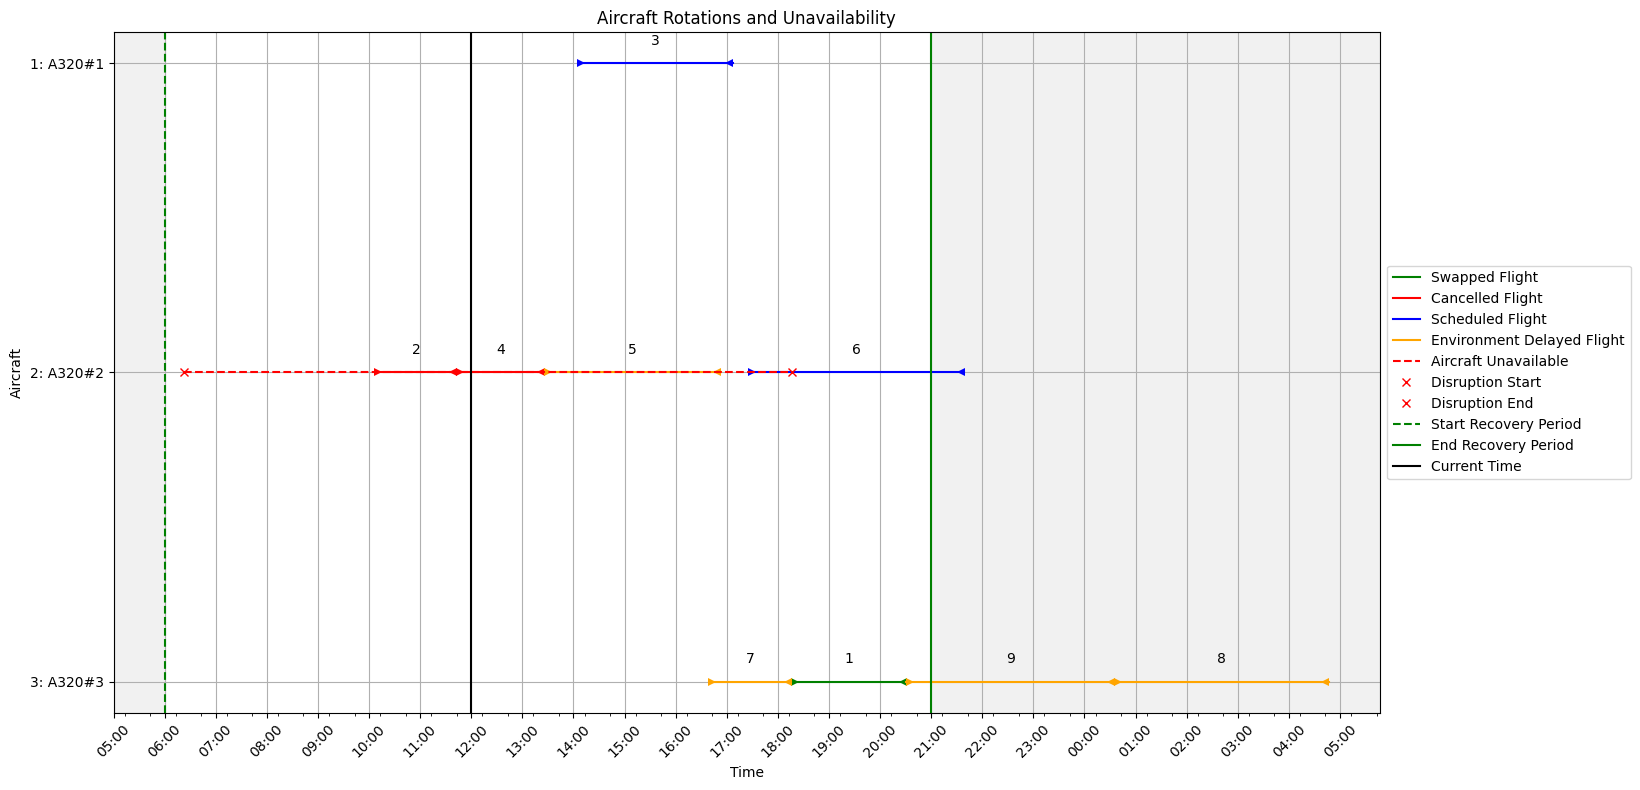

│ Target Aircraft    │ Target Flight      │ Current Time       │ Time Until End     │
│          2         │          5         │         360        │         540        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   0.15    696   756 |     3   485   667 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00     23   737 |     2   247   343 |     4   343   446 |     5   446   653 |     6   686   939 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   0.36    573   633 |     7

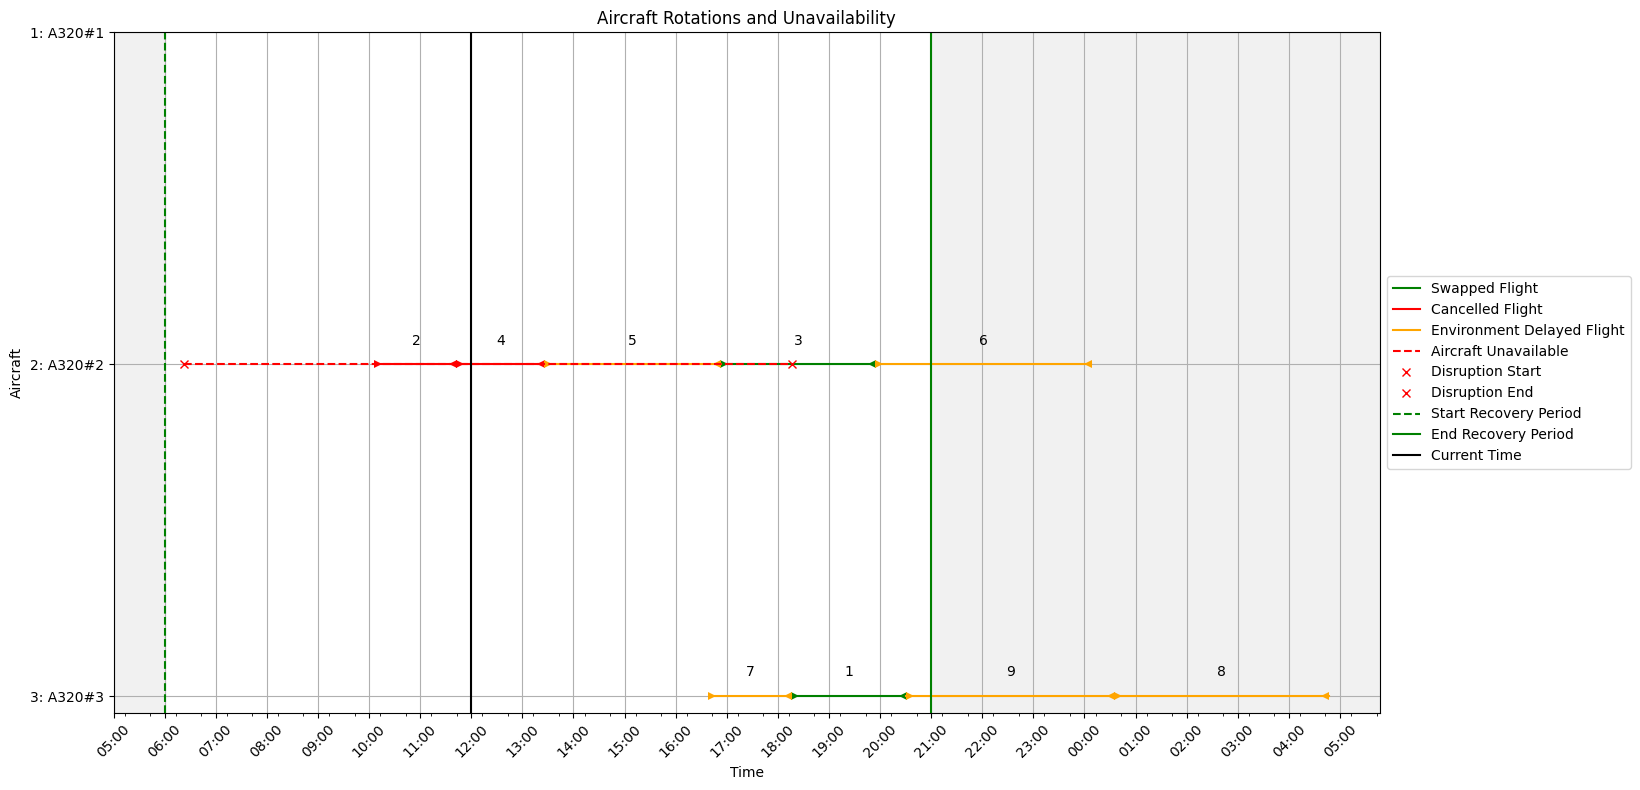

Total Reward: -8707.0


In [1]:
import os
import numpy as np
import gymnasium as gym
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from datetime import datetime, timedelta
from src.environment import AircraftDisruptionEnv
from scripts.visualizations import StatePlotter

# Run the random agent
def run_random_agent(scenario_folder):
    # Load the scenario data
    data_dict = load_scenario_data(scenario_folder)

    # Extract necessary data for the environment
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Initialize the environment
    env = AircraftDisruptionEnv(aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict)
    env = DummyVecEnv([lambda: env])

    # Reset the environment
    obs = env.reset()
    print("Observation shape:", obs.shape)

    done = False
    total_reward = 0
    step_num = 0

    # Create StatePlotter object for visualizing the environment state
    state_plotter = StatePlotter(
        aircraft_dict=aircraft_dict,
        flights_dict=flights_dict,
        rotations_dict=rotations_dict,
        alt_aircraft_dict=alt_aircraft_dict,  # Initial alt_aircraft_dict
        start_datetime=env.get_attr('start_datetime')[0],
        end_datetime=env.get_attr('end_datetime')[0]
    )

    while not done:
        # Visualize the environment at each step
        print(f"Step {step_num}:")

        # Extract necessary information from the environment for plotting
        swapped_flights = env.get_attr('swapped_flights')[0]
        environment_delayed_flights = env.get_attr('environment_delayed_flights')[0]
        current_datetime = env.get_attr('current_datetime')[0]

        # Retrieve the updated flights_dict from the environment
        updated_flights_dict = env.get_attr('flights_dict')[0]
        cancelled_flights = env.get_attr('penalized_cancelled_flights')[0]

        # Retrieve the updated alt_aircraft_dict from the environment
        updated_alt_aircraft_dict = env.get_attr('alt_aircraft_dict')[0]

        if DEBUG_MODE_VISUALIZATION:
            print("Flights Dict:")
            print(updated_flights_dict)
            print("Alt Aircraft Dict:")
            print(updated_alt_aircraft_dict)
            print("Swapped Flights:")
            print(swapped_flights)
            print("Environment Delayed Flights:")
            print(environment_delayed_flights)
            print("Cancelled Flights:")
            print(cancelled_flights)
            print("Unavailabilities:")
            print(env.get_attr('alt_aircraft_dict')[0])
            print("Uncertain Breakdowns:")
            for key, value in env.get_attr('uncertain_breakdowns')[0].items():
                print(f"{key}: {value}")
            print("Current Breakdowns:")
            print(env.get_attr('current_breakdowns')[0])
            print("")
        # Update the StatePlotter's alt_aircraft_dict
        state_plotter.alt_aircraft_dict = updated_alt_aircraft_dict

        # Plot the state using the updated alt_aircraft_dict
        state_plotter.plot_state(
            updated_flights_dict, swapped_flights, environment_delayed_flights, cancelled_flights, current_datetime
        )

        # Sample a random action
        action = np.random.randint(0, env.action_space.n, size=env.num_envs)
        # action = [0]  # Always no action

        # Step the environment
        obs, rewards, dones, infos = env.step(action)

        # Extract values from arrays
        reward = rewards[0]
        done = dones[0]

        # Accumulate the reward
        total_reward += reward

        # print(f"Action taken: {action}, Reward: {reward}")
        print("")

        step_num += 1

    # Final plot after the simulation ends
    state_plotter.plot_state(
        updated_flights_dict, swapped_flights, environment_delayed_flights, cancelled_flights, current_datetime
    )

    print(f"Total Reward: {total_reward}")

SCENARIO_FOLDER = "../Data/Testing/1k-3ac-12f-1dis-F/Scenario_01"
# SCENARIO_FOLDER = "../data/Example/Busy-scenario"

# Verify folder exists
if not os.path.exists(SCENARIO_FOLDER):
    raise FileNotFoundError(f"Scenario folder not found: {SCENARIO_FOLDER}")

# Run the random agent
run_random_agent(SCENARIO_FOLDER)
